<h1>Import graphics and array libraries.</h1>
<p>Matplotlib is used for graphing, numpy is used for generating sensor noise.  Everything else is raw python. </p>


In [16]:
import matplotlib.pyplot as plt 
import numpy as np 

<h1>Simulations of true velocity and our modeled velocity</h1>
<p>the first function shows us that our true robot velocity is a quadratic, the second shows us our predicted model. This model is wrong as it is offset and has a different power and will thus drift.  We will use sensors + the kalman filter to improve this.</p>

In [17]:
def velocity(t):
    return t ** 2
def velocity_model(t):
    return t ** 1.95 + 20

<h1>Display Measurements</h1>
<p>The plot below shows the True robots velocity vs the measured robot velocity vs the robots modeled velocity.</p>

Text(0.5, 1.0, 'True Velocity vs Noisy Measured Velocity vs Drifting Velocity Model')

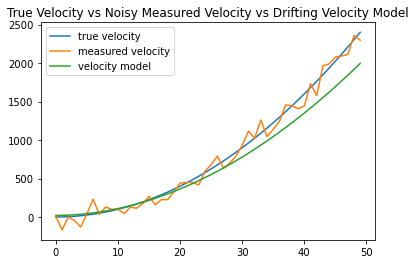

In [40]:
num_samples = 50
true_velocity = [velocity(t) for t in range(num_samples)]
model_of_velo = [velocity_model(t) for t in range(num_samples)]
noise = np.random.normal(0,100,num_samples)
measured_velocity = [true_velocity[i] + noise[i] for i in range(len(true_velocity))]
plt.plot(true_velocity,label = "true velocity")
plt.plot(measured_velocity,label = "measured velocity")
plt.plot(model_of_velo, label = "velocity model")
plt.legend()
plt.title("True Velocity vs Noisy Measured Velocity vs Drifting Velocity Model")

<h1>Kalman Filter Algorithm</h1>
<p>Higher values of Q trust our sensors more, R puts more trust in our model.  We then perform several iterations to find the optimal kalman gain.</p>

In [ ]:
def kalmanFilter(measurements):
    estimate = measurements[0]
    previousEstimate = estimate
    estimates = []
    K_vals = []
    estimates.append(0)
    Q = 0.4
    R = 3
    P = 1 
    K = 0 
    for i in range(len(measurements)):
        P = P + Q 
        K = P / (P + R)
        K_vals.append(K)
        P = (1-K) * P
    for i in range(1,len(measurements)):
        estimate += model_of_velo[i] - model_of_velo[i - 1]
        estimate += K * (measurements[i] - estimate)
        estimates.append(estimate)
        previousEstimate = estimate
    return estimates, K_vals

<h1>Kalman Filter Results!</h1>
<p>Here we can see the kalman filter manages to filter out noise from the sensor and rejects the drift of the model.</p>

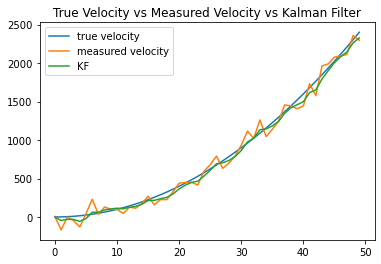

In [42]:
estimates, K_vals = kalmanFilter(measured_velocity)
plt.plot(true_velocity,label = "true velocity")
plt.plot(measured_velocity,label = "measured velocity")
plt.plot(estimates, label = "KF")

plt.title("True Velocity vs Measured Velocity vs Kalman Filter")
plt.legend()


<h1>Kalman Gain</h1>
<p>Here we can see the kalman gain converge to it's final value.</p>

Text(0.5, 1.0, 'Kalman gain convergence')

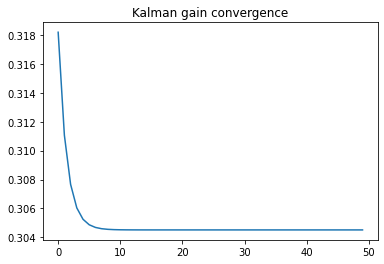

In [48]:
plt.plot(K_vals)
plt.title("Kalman gain convergence")

Text(0.5, 1.0, 'Kalman filter output vs the true velocity')

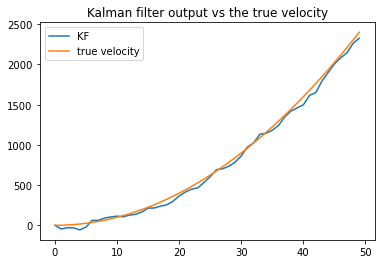

In [50]:
plt.plot(estimates, label = "KF")
plt.plot(true_velocity,label = "true velocity")
plt.legend()
plt.title("Kalman filter output vs the true velocity")

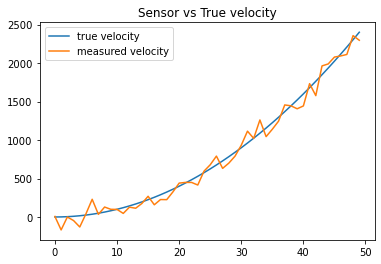

In [51]:
plt.plot(true_velocity,label = "true velocity")
plt.plot(measured_velocity,label = "measured velocity")
plt.title("Sensor vs True velocity")
plt.legend()

<h1>How well did we do?</h1>
<p>By calculating the MSE of the predicted values vs the measured values we can assess how much better our kalman filter is than our sensors.</p>

In [56]:
def MSE(predictedVals, observedVals):
    MSE = 0
    for i in range(len(predictedVals)):
        MSE += (predictedVals[i] - observedVals[i]) ** 2
        
    MSE *= 1/len(predictedVals)
    return MSE

In [57]:
measuredMSE = MSE(true_velocity, measured_velocity)
measuredMSE


7691.034392218347

In [58]:
estimatedMSE = MSE(true_velocity, estimates)
estimatedMSE


2077.6157911759033

In [59]:
print(f"the sensor has {(measuredMSE / estimatedMSE) * 100}% more error than the kalman filter estimate")

the sensor has 370.18559566614204% more error than the kalman filter estimate


<h1>How does this fair against other approaches?</h1>
<p>We see that the kalman filter out performs just the raw sensor / model.  The question is, how does this alogirthm compare against other approaches such as the low pass filter? As we can see below the low pass filter is able to help remove some sensor noise but introduced a significant amount of phase lag.  The kalman filter does not have nearly as much lag.</p>

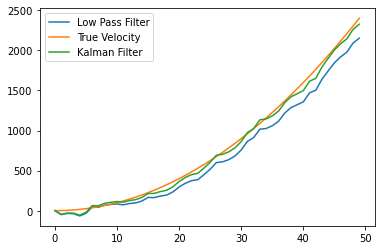

In [63]:
prevEstimate = 0
A = 0.7
def lowPassFilter(x):
    global prevEstimate
    estimate = A * prevEstimate + (1 - A) * x
    prevEstimate = estimate
    return estimate

minimumA = 0.0001


low_pass_velocity = [lowPassFilter(measured_velocity[i]) for i in range(len(measured_velocity))]
plt.plot(low_pass_velocity,label = "Low Pass Filter")
plt.plot(true_velocity,label = "True Velocity")
plt.plot(estimates,label = "Kalman Filter")
plt.legend()